In [67]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import RandomSampler

"""Change to the data folder"""
new_path = "./new_train/new_train"
val_path = "./new_val_in/new_val_in" 
# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

In [68]:
torch.cuda.is_available()

False

### Create a dataset class 

In [69]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
train_dataset  = ArgoverseDataset(data_path=new_path)

### Check input/output distribution
#### Create Loader

In [257]:
batch_sz = 1

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp_x = np.array([np.array(x).flatten() for x in [scene['p_in'] for scene in batch]])[0][::2]
    out_x = np.array([np.array(x).flatten() for x in [scene['p_out'] for scene in batch]])[0][::2]
    inp_y = np.array([np.array(x).flatten() for x in [scene['p_in'] for scene in batch]])[0][1::2]
    out_y = np.array([np.array(x).flatten() for x in [scene['p_out'] for scene in batch]])[0][1::2]
    
    inp_vx = np.array([np.array(x).flatten() for x in [scene['v_in'] for scene in batch]])[0][::2]
    inp_vy = np.array([np.array(x).flatten() for x in [scene['v_in'] for scene in batch]])[0][1::2]

    return [inp_x, inp_y, out_x, out_y, inp_vx, inp_vy]

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0, drop_last=True)


#### Extract values of input/output

In [151]:
def round_down(num):
    return num - (num%100)

dct_inpx = defaultdict(int)
dct_outx = defaultdict(int)
dct_inpy = defaultdict(int)
dct_outy = defaultdict(int)
dct_inpvx = defaultdict(int)
dct_inpvy = defaultdict(int)

for i_batch, batch in tqdm(enumerate(train_loader)):
    inp_x, inp_y, out_x, out_y, inp_vx, inp_vy  = batch
    inp_x = [x for x in inp_x if x != 0]
    out_x = [x for x in out_x if x != 0]
    inp_y = [x for x in inp_y if x != 0]
    out_y = [x for x in out_y if x != 0]
    inp_vx = [x for x in inp_vx if x != 0]
    inp_vy = [x for x in inp_vy if x != 0]
    
    for i in inp_x:
        dct_inpx[(round_down(i) + 50)] += 1
    for o in out_x:
        dct_outx[(round_down(o) + 50)] += 1
    for i in inp_y:
        dct_inpy[(round_down(i) + 50)] += 1
    for o in out_y:
        dct_outy[(round_down(o) + 50)] += 1
    for i in inp_vx:
        dct_inpvx[(round_down(i) + 50)] += 1
    for o in inp_vy:
        dct_inpvy[(round_down(o) + 50)] += 1

0it [00:00, ?it/s]

In [262]:
def round_down_500(num):
    return num - (num%500)

new_inpx = defaultdict(int)
for key in dct_inpx.keys():
    new_inpx[round_down_500(key)+250] += dct_inpx[key]

new_outx = defaultdict(int)
for key in dct_outx.keys():
    new_outx[round_down_500(key)+250] += dct_outx[key]
    
new_inpy = defaultdict(int)
for key in dct_inpy.keys():
    new_inpy[round_down_500(key)+250] += dct_inpy[key]

new_outy = defaultdict(int)
for key in dct_outy.keys():
    new_outy[round_down_500(key)+250] += dct_outy[key]
    
new_inpvx = defaultdict(int)
for key in dct_inpvx.keys():
    new_inpvx[round_down_500(key)+250] += dct_inpvx[key]

new_inpvy = defaultdict(int)
for key in dct_inpvy.keys():
    new_inpvy[round_down_500(key)+250] += dct_inpvy[key]

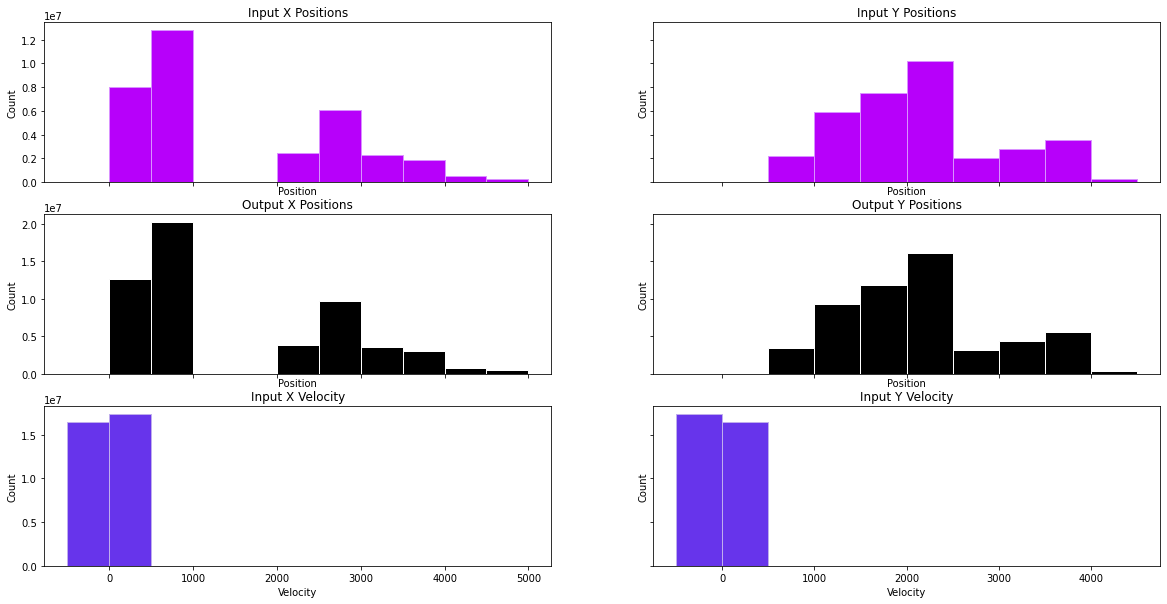

In [263]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(20,10))
# f.subplots_adjust(hspace=.5)
ax1.bar(new_inpx.keys(), new_inpx.values(), width=500, facecolor='#b700fa', edgecolor='#d991ff')
ax1.set_xlabel('Position')
ax1.set_ylabel('Count')
ax1.set_title('Input X Positions')

ax2.bar(new_inpy.keys(), new_inpy.values(), width=500, facecolor='#b700fa', edgecolor='#d991ff')
ax2.set_xlabel('Position')
ax2.set_ylabel('Count')
ax2.set_title('Input Y Positions')

ax3.bar(new_outx.keys(), new_outx.values(), width=500, facecolor='black', edgecolor='white')
ax3.set_xlabel('Position')
ax3.set_ylabel('Count')
ax3.set_title('Output X Positions')

ax4.bar(new_outy.keys(), new_outy.values(), width=500, facecolor='black', edgecolor='white')
ax4.set_xlabel('Position')
ax4.set_ylabel('Count')
ax4.set_title('Output Y Positions')

ax5.bar(new_inpvx.keys(), new_inpvx.values(), width=500, facecolor='#6734eb', edgecolor='#bfaded')
ax5.set_xlabel('Velocity')
ax5.set_ylabel('Count')
ax5.set_title('Input X Velocity')

ax6.bar(new_inpvy.keys(), new_inpvy.values(), width=500, facecolor='#6734eb', edgecolor='#bfaded')
ax6.set_xlabel('Velocity')
ax6.set_ylabel('Count')
ax6.set_title('Input Y Velocity')

plt.savefig('distributions.png')

In [261]:
for i_batch, batch in enumerate(train_loader):
    print(batch[5])
    break

[-0.00023823 -0.00036088 -0.00143323 ...  0.          0.
  0.        ]


In [235]:
# json.dump(dct_inpx, open('inpx_bins.json', 'w'))
# json.dump(dct_outx, open('outx_bins.json', 'w'))
# json.dump(dct_inpy, open('inpy_bins.json', 'w'))
# json.dump(dct_outy, open('outy_bins.json', 'w'))
# json.dump(dct_inpvx, open('inpvx_bins.json', 'w'))
# json.dump(dct_inpvy, open('inpvy_bins.json', 'w'))

### Determining number of agents

In [264]:
batch_sz = 1

def my_collate_agents(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    agents = sum(np.array([scene['car_mask'] for scene in batch]).flatten())

    return agents

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate_agents, num_workers=0, drop_last=True)


In [266]:
num_agents = []
for i_batch, batch in tqdm(enumerate(train_loader)):
    num_agents.append(batch)

0it [00:00, ?it/s]

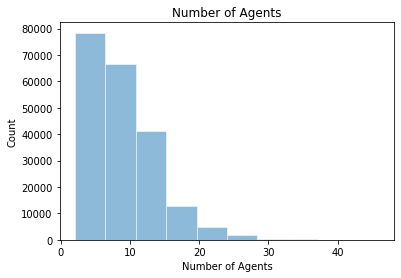

In [274]:
plt.hist(num_agents, alpha=0.5, edgecolor='white')
plt.title("Number of Agents")
plt.xlabel('Number of Agents')
plt.ylabel("Count")
plt.savefig('agents.png')

In [277]:
print("Mean: {}".format(np.mean(num_agents)))
print("Max: {}".format(np.max(num_agents)))
print("Min: {}".format(np.min(num_agents)))
print("STD: {}".format(np.std(num_agents)))

Mean: 8.799424109700789
Max: 46.0
Min: 2.0
STD: 4.814979904748634


In [324]:
# json.dump(num_agents, open('agents.json', 'w'))

### Analyzing Distance

In [321]:
batch_sz = 1

def my_collate_distance(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [scene['p_in'] for scene in batch]
    out = [scene['p_out'] for scene in batch]
    agent = [scene['agent_id'] for scene in batch]
    track = [scene['track_id'] for scene in batch]
    track_ids = []
    for scene in range(len(agent)):
        for track_id in range(len(track[scene])):
            if agent[scene] == track[scene][track_id][0][0]:
                track_ids.append(track_id)
                break
    return [np.array([inp[0][track_id][0][0], inp[0][track_id][0][1]]), np.array([out[0][track_id][-1][0], out[0][track_id][-1][1]])]

    return distance

train_loader = DataLoader(train_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate_distance, num_workers=0, drop_last=True)


In [325]:
distances = []
for i_batch, batch in tqdm(enumerate(train_loader)):
    inp, out = batch
    dist = np.linalg.norm(inp - out)
    distances.append(dist)

0it [00:00, ?it/s]

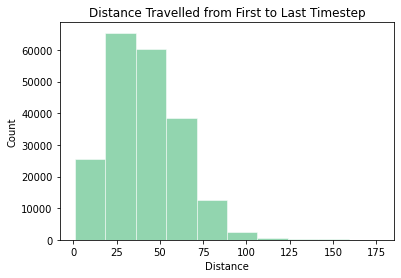

In [328]:
plt.hist(distances, alpha=0.5, facecolor='#26ad61', edgecolor='white')
plt.title("Distance Travelled from First to Last Timestep")
plt.xlabel('Distance')
plt.ylabel("Count")
plt.savefig('distance.png')

In [329]:
print("Mean: {}".format(np.mean(distances)))
print("Max: {}".format(np.max(distances)))
print("Min: {}".format(np.min(distances)))
print("STD: {}".format(np.std(distances)))

Mean: 41.501465819175955
Max: 176.73225867264216
Min: 0.8224763962545945
STD: 20.198842089515555


In [326]:
# json.dump(distances, open('distance.json', 'w'))

### Visualize the batch of sequences

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


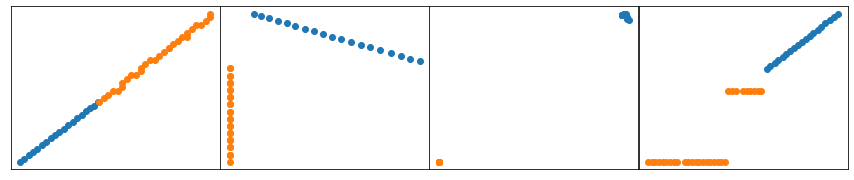

In [31]:
import matplotlib.pyplot as plt
import random

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    """TODO:
      Deep learning model
      training routine
    """
    show_sample_batch(sample_batch, agent_id)
    break